In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
from scipy.signal import tukey
from scipy.optimize import minimize

In [2]:
def build_fun(tmax, fmax, freqs, data, psds, trigtime, srate, seglen, bounds):
    def fun(x, t=tmax, f=fmax, data=data, psds=psds, trig=trigtime,seglen=seglen, srate=srate, bounds=bounds):
        for i, val in enumerate(x):
            min, max = bounds[i]
            if min < val < max:
                continue
            else:
                return np.inf
        A, p, Q = x
        asd = psds ** (1/2.)
        gl = build_FD_glitch(A, p, Q, t, f, asd, seglen, srate, trigtime=trig)
        return -logl(freqs, gl, data, psds)
    return fun

def logl(freqs, gl, d, psd, flow=10.):
    df = freqs[1]-freqs[0]
    sel = freqs > flow
    gg = np.sum(4.0*df*(gl.conj()[sel]*gl[sel]).real/psd[sel])
    gd = np.sum(4.0*df*(d.value.conj()[sel]*gl[sel]).real/psd[sel])
    logl = -0.5*(gg - 2.0*gd)
    return logl

def build_FD_glitch(A, p, Q, t, f, asd, seglen, srate, trigtime=None):
    dT = 1 / srate
    dF = 1 / seglen
    if ~(0 <= t < seglen) and trigtime is not None:
        t = trigtime-t+seglen-2
    Anorm = (2*seglen) / (srate ** 2.)
    Tobs = seglen
    fLow = 10.
    fHigh = srate/2.
    low = np.ceil(fLow / dF)
    high = np.floor(fHigh / dF)-1
    FD_glitch = np.zeros(int(srate*seglen/2)+1, dtype=np.complex)
    A = A*Anorm
    tau = Q/(2*np.pi) / f
    glitchLow = int(np.floor((f - 1. / tau) / dF))
    glitchHigh = int(np.ceil((f + 1 / tau) / dF))
    for i in range(glitchLow, glitchHigh):
        if i >= low and i <= high:
            amparg = (i * dF - f) * np.pi * tau
            phasearg = np.pi * i + p - 2 * np.pi * i * dF * (t-Tobs/2.)
            Ai = A * tau * 0.5 * np.sqrt(np.pi) * np.exp(-amparg * amparg) *asd[i] / np.sqrt(Tobs)
            real = Ai * np.cos(phasearg)
            imag = Ai * np.sin(phasearg)

            FD_glitch[i] = real + 1j * imag
    return FD_glitch

In [3]:
seglen = 8.
srate = 1024.
trigtime = 1126103127.521729
L1_data_files = ['L-L1_HOFT_C01-112609686-4096.gwf', 'L-L1_HOFT_C01-1126100992-4096.gwf', 'L-L1_HOFT_C01-1126105088-4096.gwf']
L1_channel = 'L1:DCS-CALIB_STRAIN_C01'
L1_psd_file = '1126103127.522_L1-PSD.dat'

In [4]:
def plot_spec(spec, tf, trig, seglen):
    t, f = tf
    plt.figure(figsize=(15, 10))
    spec.plot()
    ax = plt.gca()
    ax.set_epoch(trig)
    plt.xlim(trig-seglen+2, trig+2)
    plt.yscale('log')
    plt.scatter(t, f, marker='x', s=25, color='r', zorder=10)

def tukey_window(ts, seglen, a=0.4):
    window = tukey(len(ts), alpha=a/seglen)
    return ts*window

In [57]:
start = trigtime-seglen+2
end = trigtime+2

L1_ts = TimeSeries.read(L1_data_files, L1_channel, start=start, end=end)
L1_qtranf = L1_ts.q_transform()
t_max_idx, f_max_idx = np.unravel_index(np.argmax(L1_qtranf), L1_qtranf.shape)
L1_fs = tukey_window(L1_ts.resample(1024.), seglen).fft()
t_max = L1_qtranf.times[t_max_idx].value
f_max = L1_qtranf.frequencies[f_max_idx].value
print(t_max_idx, f_max_idx)

(750, 271)


/home/bedelman/.local/lib/python2.7/site-packages/gwpy/timeseries/timeseries.py:948: UserWarning: resample() rate matches current sample_rate (1024.0 Hz), returning input data unmodified; please double-check your parameters
  UserWarning,


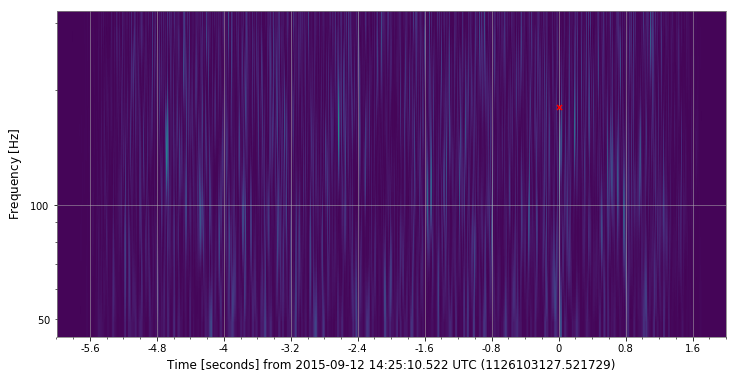

In [58]:
plot_spec(L1_qtranf, [t_max, f_max], trigtime, seglen)

In [60]:
Anorm = (2*seglen) / (srate ** 2.)
np.random.seed(10)
Amin, Amax = 10/Anorm, 1000/Anorm
phiMin, phiMax = 0, 2*np.pi
Qmin, Qmax = 3, 30
Amp0 = Amin+(Amax-Amin)*np.random.rand()
phi0 = phiMin+(phiMax-phiMin)*np.random.rand()
Q0 = Qmin+(Qmax-Qmin)*np.random.rand()

In [61]:
tmp = np.genfromtxt(L1_psd_file)
L1_freqs, L1_psd = tmp[:,0], tmp[:,1]
FD = build_FD_glitch(Amp0, phi0, Q0, t_max, f_max, L1_psd**(1/2.),seglen, srate, trigtime=trigtime)

In [62]:
glitch_fs = FrequencySeries(data = FD, frequencies=L1_fs.frequencies.value)

In [63]:
def plot_data_glitch_fs(data, glitch, srate=srate, fmax=f_max):
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex='all',figsize=(12, 8))
    axs[0].loglog(data.frequencies, np.abs(data))
    axs[0].set_ylabel('Strain Amplitude (m)')
    axs[1].set_ylabel('Strain Amplitude (m)')
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_title('L1 Strain data FD')
    axs[1].loglog(data.frequencies, np.abs(glitch))
    axs[1].set_title('Glitch Amplitude FD')
    axs[0].set_xlim(10., srate/2.)
    axs[0].axvline(fmax,color='r')
    axs[1].axvline(fmax, color='r')
    axs[2].loglog(data.frequencies, np.abs(data-glitch))
    axs[2].set_ylabel('Strain Amplitude (m)')
    axs[2].axvline(fmax,color='r')

    axs[2].set_title('Glitch-data diff Amplitude FD')
    plt.subplots_adjust(hspace=0.5)

    
def plot_data_glitch_ts(data, glitch, srate=srate, tmax=t_max, trigtime=trigtime, seglen=seglen):
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex='all',figsize=(12, 8))
    axs[0].plot(data.times, data)
    axs[0].set_ylabel('Strain Amplitude (m)')
    axs[1].set_ylabel('Strain Amplitude (m)')
    axs[0].set_xlabel('Time(sec)')
    axs[0].set_title('L1 Strain data TD')
    axs[1].plot(glitch.times.value, glitch)
    axs[1].set_title('Glitch Amplitude TD')
    axs[0].set_xlim(trigtime-6., trigtime+2.)
    axs[0].axvline(tmax,color='r')
    axs[1].axvline(tmax, color='r')
    axs[2].axvline(tmax, color='r')
    axs[2].plot(data.times, data.value-glitch.value)
    axs[2].set_ylabel('Strain (m)')
    axs[2].set_title('data- glitch subraction')
    plt.subplots_adjust(hspace=0.5)

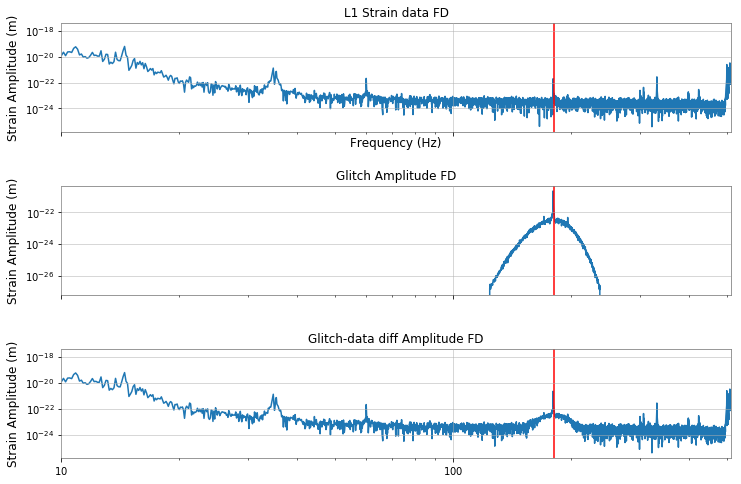

In [64]:
plot_data_glitch_fs(L1_fs, FD)

In [65]:
def time_sens_ifft(fs, data):
    nout = (fs.size - 1) * 2
    dift = np.fft.irfft(fs.value * nout) / 2
    new = TimeSeries(dift, epoch=fs.epoch, times=data.times)
    return new

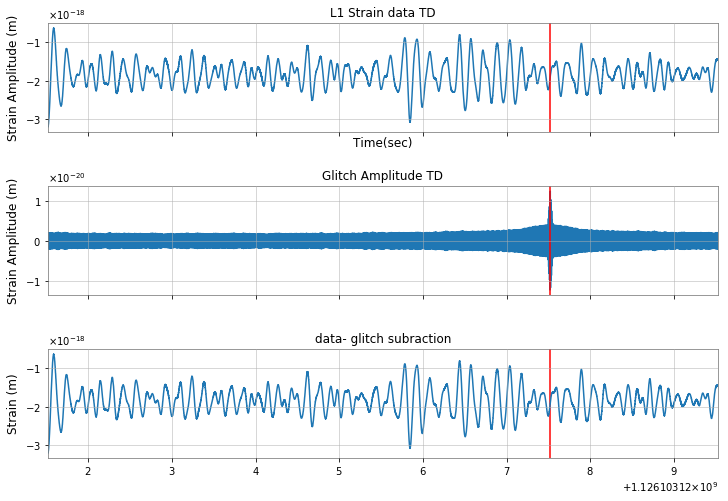

In [66]:
#glitch_ts = glitch_fs.ifft()
glitch_ts = time_sens_ifft(glitch_fs, L1_ts.resample(1024))
plot_data_glitch_ts(L1_ts.resample(1024), glitch_ts)

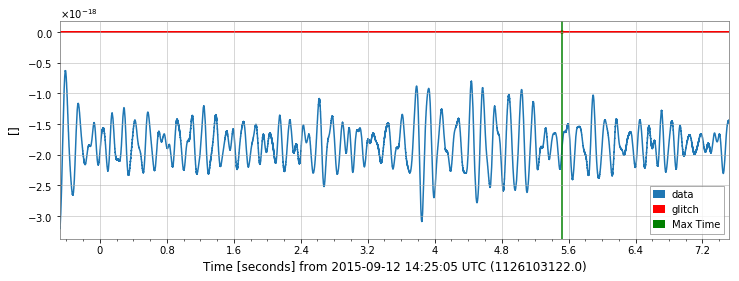

In [67]:
pl = L1_ts.plot(label='data')
ax = pl.gca()
ax.plot(glitch_ts.times.value, glitch_ts, color='r', label='glitch')
ax.axvline(t_max, color='g', label='Max Time')
plt.legend()

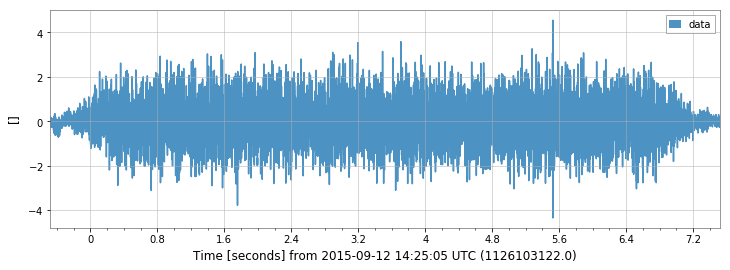

In [68]:
white = L1_ts.whiten()
white_glitch= glitch_ts.whiten()
pl = white.plot(label='data', alpha=0.8)
ax = pl.gca()
#ax.plot(white_glitch.times.value, white_glitch, color='r', label='glitch', alpha=0.75)
#ax.axvline(t_max, color='g', label='Max Time')
plt.legend()

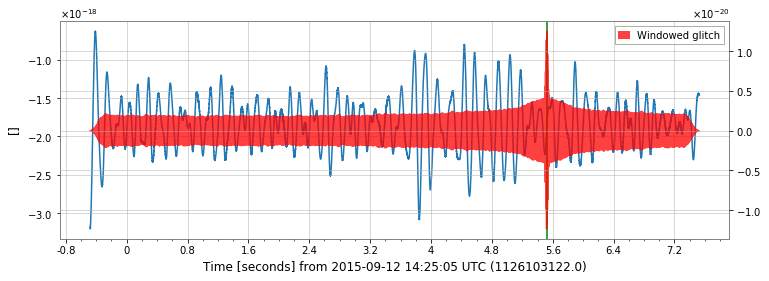

In [69]:
pl = L1_ts.plot(label='data')
ax = pl.gca()
ax2 = ax.twinx()
ax2.plot(glitch_ts.times.value, tukey_window(glitch_ts,seglen), color='r', label='Windowed glitch', alpha=0.75)
ax.axvline(t_max, color='g', label='Max Time')
plt.legend()

In [70]:
glitch_spec = tukey_window(glitch_ts, seglen).q_transform(whiten=False)
print(glitch_ts.times.value)
print(glitch_spec.times.value)

#times = np.linspace(L1_ts.times.value.min(), L1_ts.times.value.max(), glitch_spec.times.shape[0])
#glitch_spec.times = times

[1.12610312e+09 1.12610312e+09 1.12610312e+09 ... 1.12610313e+09
 1.12610313e+09 1.12610313e+09]
[1.12610312e+09 1.12610312e+09 1.12610312e+09 ... 1.12610313e+09
 1.12610313e+09 1.12610313e+09]


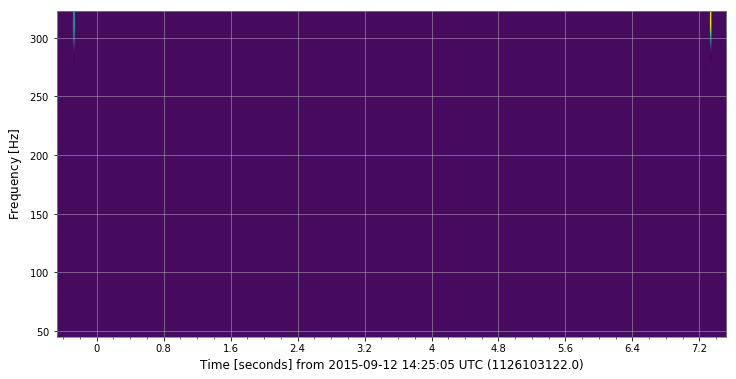

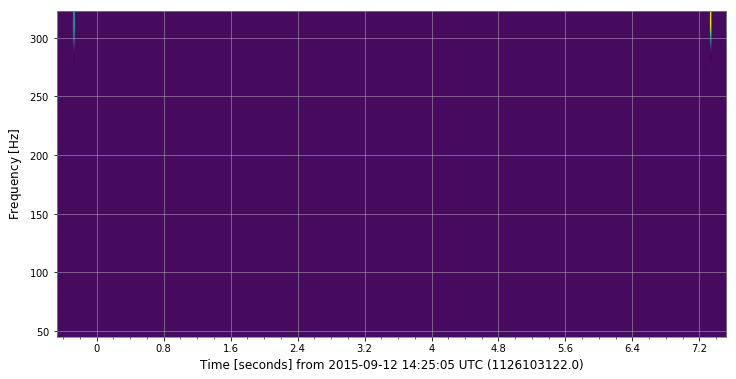

In [71]:
glitch_spec.plot()

(10.0, 512.0)

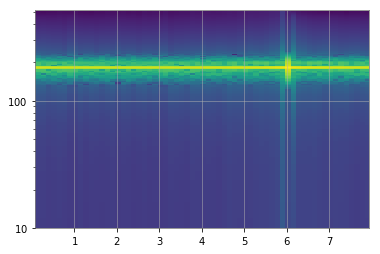

In [72]:
plt.specgram(glitch_ts, Fs=srate);
plt.yscale('log')
plt.ylim(10., srate/2.)

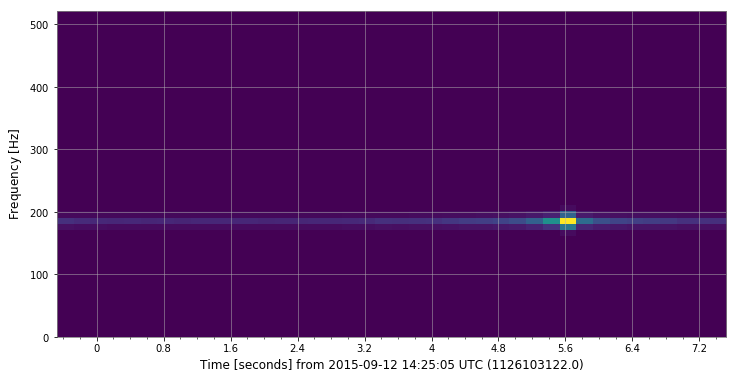

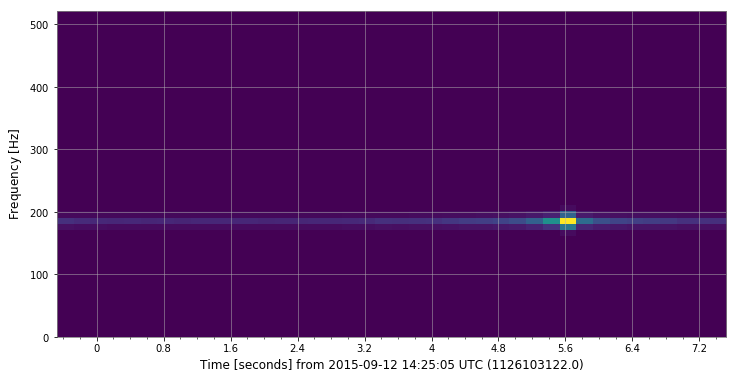

In [73]:
glitch_ts.spectrogram(0.2, 0.1).plot()

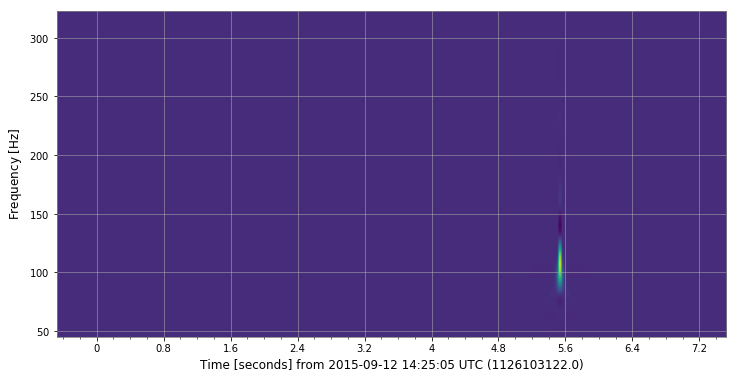

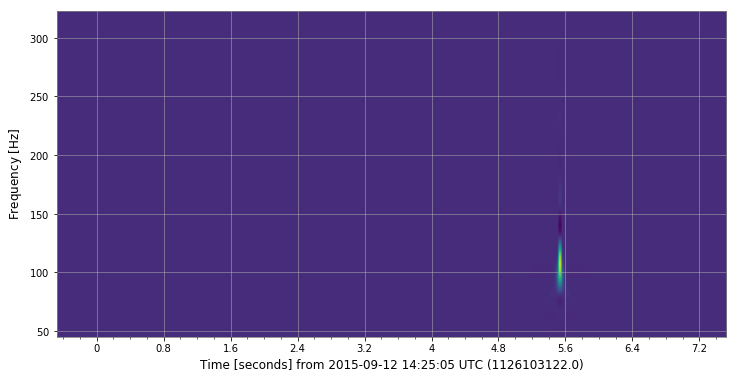

In [74]:
glitch_ts.q_transform(whiten=False).plot()

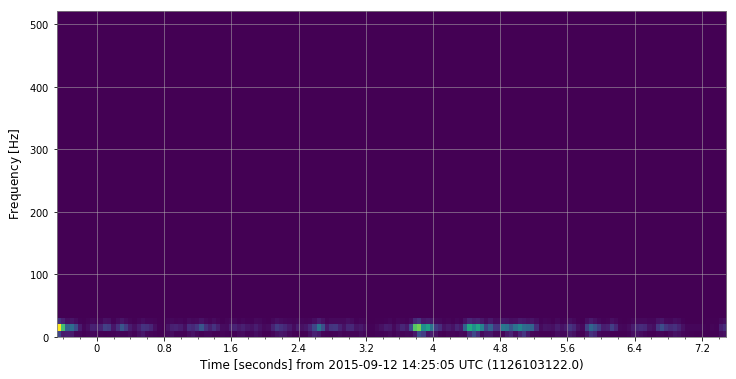

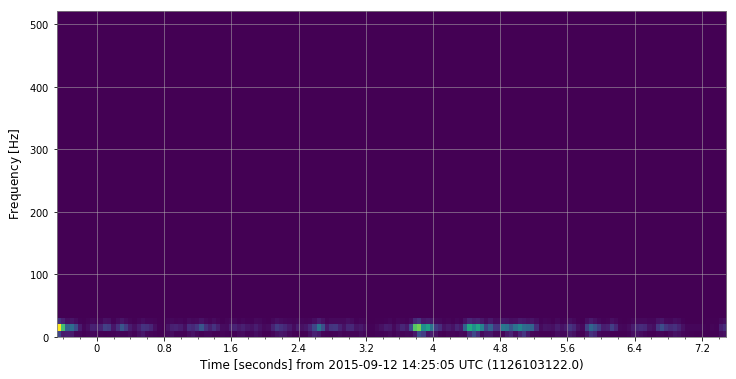

In [75]:
L1_ts.resample(1024).spectrogram2(0.1).plot()
#plt.ylim(10., srate/2.)

1.24848362456e-20
13.5385608673
-54.102230072
(749, 278)


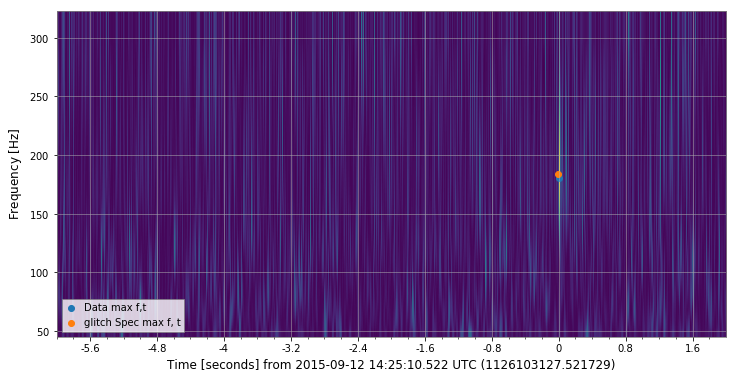

In [76]:
print(glitch_ts.max())
plt_ts = glitch_ts.copy()
ts = TimeSeries(np.random.randn(len(glitch_ts))*.5*1e-20, times=glitch_ts.times)
plt_ts += ts
q_Tr = plt_ts.q_transform(whiten=False)
pl = q_Tr.plot()
ax = pl.gca()
ax.set_epoch(trigtime)

ax.scatter(t_max, f_max, label='Data max f,t');
t, f = np.unravel_index(np.argmax(q_Tr), q_Tr.shape)
print(glitch_spec[t, f])
print(glitch_spec[t_max_idx, f_max_idx])
print(np.unravel_index(np.argmax(q_Tr), q_Tr.shape))
ax.scatter(q_Tr.times[t], q_Tr.frequencies[f], label='glitch Spec max f, t')
ax.legend(loc='lower left')


In [77]:
from gwpy.segments import Segment
from matplotlib.cm import get_cmap

def plot_qscan(ts, trigtime, flow):
    seglen = ts.duration.value
    srate = ts.sample_rate.value
    search = Segment(trigtime-0.25, trigtime+0.25)
    qgram = ts.q_gram(qrange=(4, 150), search=search, mismatch=0.35)
    cmap = get_cmap('viridis')
    plot = qgram.tile('time', 'frequency', 'duration', 'bandwidth',
                  color='energy', figsize=[12, 8], linewidth=0.1,
                  edgecolor=cmap(0), antialiased=True)
    ax = plot.gca()
    ax.set_xscale('seconds')
    ax.set_xlim(trigtime-seglen+2, trigtime+2)
    ax.set_epoch(trigtime)
    ax.set_yscale('log')
    ax.set_ylim(flow, srate/2.)
    ax.set_ylabel('Frequency [Hz]')
    ax.grid(True, axis='y', which='both')
    ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
    cmap = get_cmap('viridis')
    ax.set_facecolor(cmap(0))

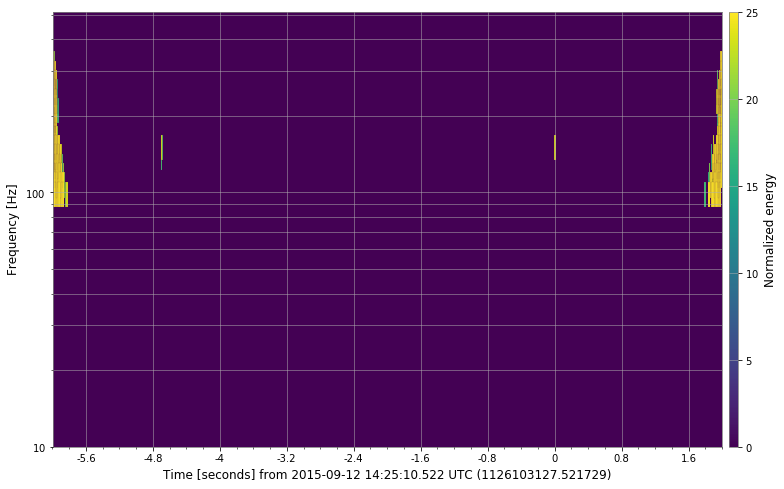

In [78]:
plot_qscan(L1_ts, trigtime, 10.)


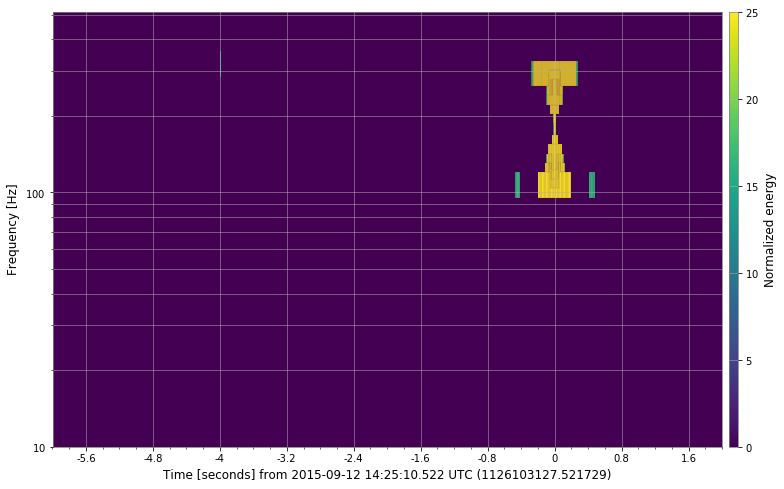

In [79]:
plot_qscan(glitch_ts, trigtime, 10.)

In [80]:
clean_fs = plt_ts.fft()
x0 = (Amp0, phi0, Q0)
bounds=((Amin, Amax), (phiMin, phiMax), (Qmin, Qmax))
print(x0)
logl_func = build_fun(t_max, f_max, L1_freqs, clean_fs, L1_psd, trigtime, srate, seglen, bounds)
print(logl_func(x0))

(50699136.98035817, 0.13038834331032634, 20.108502343009437)
-721.905114676183


In [81]:
sol = minimize(logl_func, x0, options={'disp': True, 'maxiter': 20}, method='powell')# bounds=((Amin, Amax), (phiMin, phiMax), (Qmin, Qmax)))
sol

Optimization terminated successfully.
         Current function value: -766.144289
         Iterations: 4
         Function evaluations: 229


   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: -766.1442889103805
 message: 'Optimization terminated successfully.'
    nfev: 229
     nit: 4
  status: 0
 success: True
       x: array([4.52218377e+07, 7.17970305e-11, 2.34044009e+01])

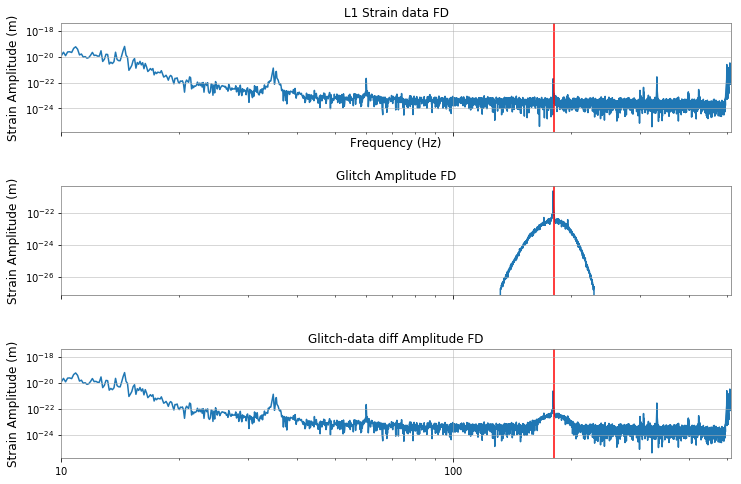

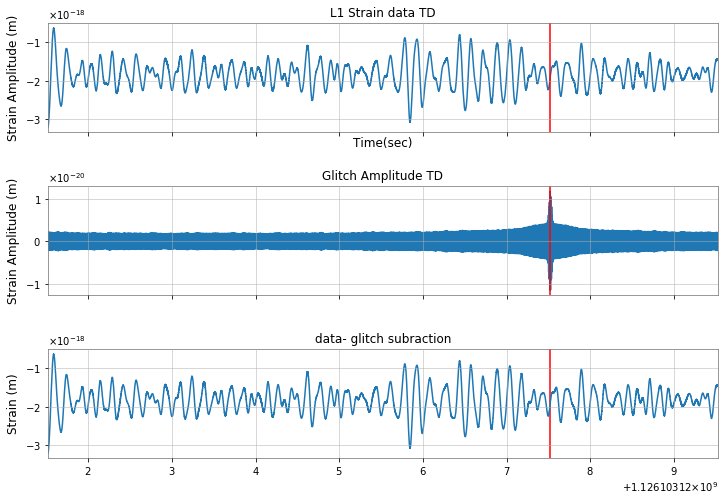

In [82]:
FD = build_FD_glitch(sol.x[0], sol.x[1],sol.x[2], t_max, f_max, L1_psd**(1/2.),seglen, srate, trigtime=trigtime)
glitch_fs = FrequencySeries(data = FD, frequencies=L1_fs.frequencies.value)
glitch_ts = time_sens_ifft(glitch_fs, L1_ts.resample(1024))
plot_data_glitch_fs(L1_fs, FD)
plot_data_glitch_ts(L1_ts.resample(1024), glitch_ts)

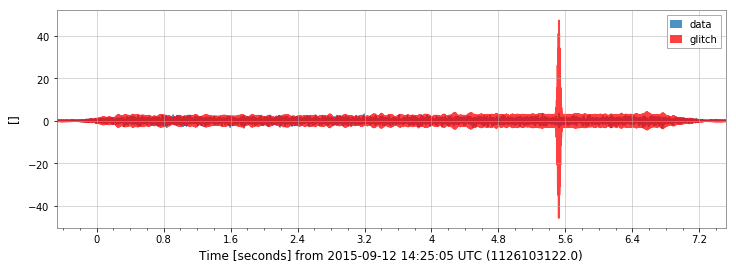

In [83]:
asd = FrequencySeries(L1_psd**(1/2.), frequencies=L1_freqs)
white = L1_ts.resample(1024.).whiten(asd=asd)
white_glitch= glitch_ts.whiten(asd=asd)
pl = white.plot(label='data', alpha=0.8)
ax = pl.gca()
ax.plot(white_glitch.times.value, white_glitch, color='r', label='glitch', alpha=0.75)
#ax.axvline(t_max, color='g', label='Max Time')
plt.legend()

Text(0.5,1,'Glitch Reconstruction Q transform')

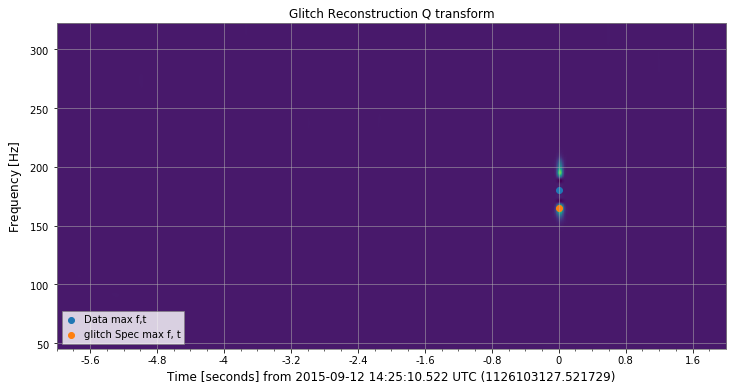

In [84]:
plt_ts = glitch_ts.copy()
ts = TimeSeries(np.random.randn(len(glitch_ts))*.01e-20, times=glitch_ts.times)
plt_ts += ts
q_Tr = plt_ts.q_transform(whiten=False, fres=1./seglen)
pl = q_Tr.plot()
ax = pl.gca()
ax.set_epoch(trigtime)

ax.scatter(t_max, f_max, label='Data max f,t');
t, f = np.unravel_index(np.argmax(q_Tr), q_Tr.shape)
ax.scatter(q_Tr.times[t], q_Tr.frequencies[f], label='glitch Spec max f, t')
ax.legend(loc='lower left')
ax.set_title('Glitch Reconstruction Q transform')

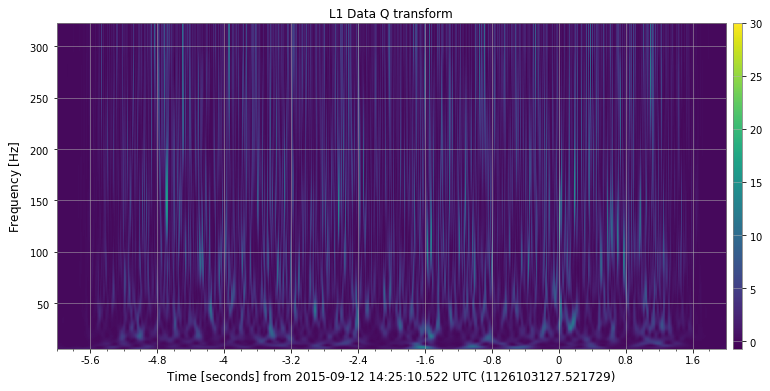

In [85]:
plt_ts = L1_ts.resample(1024).copy()
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1 Data Q transform')
ax.colorbar()
data_Q = q_Tr.q

Text(0.5,1,'L1_data - Glitch Q_transform')

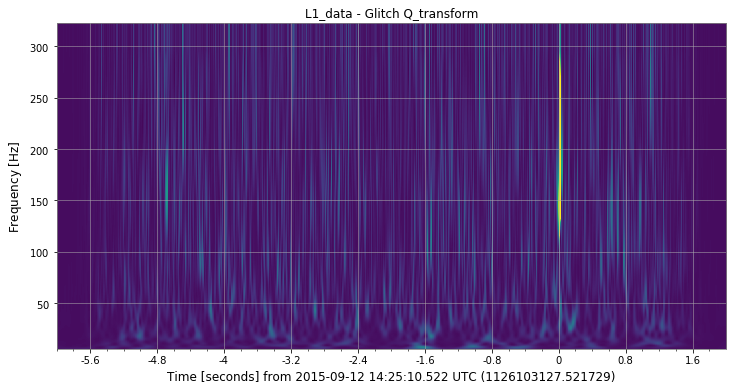

In [86]:
plt_ts = L1_ts.resample(1024).copy()
plt_ts -= glitch_ts
q_Tr = plt_ts.q_transform(qrange=(data_Q, data_Q))
pl = q_Tr.plot(vmax=30)
ax = pl.gca()
ax.set_epoch(trigtime)
ax.set_title('L1_data - Glitch Q_transform')
